In [58]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")

# Daily

## Structure Overview

In [59]:
path_1="..\Bellabeat data analysis\data\Fitabase Data 3.12.16-4.11.16"
path_2 = "..\Bellabeat data analysis\data\Fitabase Data 4.12.16-5.12.16"
activity_daily_1=pd.read_csv(path_1 + "\dailyActivity_merged.csv")
activity_daily_2=pd.read_csv(path_2 + "\dailyActivity_merged.csv")
activity_daily_1['ActivityDate'] = pd.to_datetime(activity_daily_1['ActivityDate'])
activity_daily_2['ActivityDate'] = pd.to_datetime(activity_daily_2['ActivityDate'])

In [60]:
print("The columns match:", list(activity_daily_1.columns) == list(activity_daily_2.columns))
print("\nDifferences in column names:")
print(set(activity_daily_1.columns).symmetric_difference(set(activity_daily_2.columns)))
print("\nData types in the first set:")
print(activity_daily_1.dtypes)
print("\nData types in the second set:")
print(activity_daily_2.dtypes)
print("\nRange 1:", activity_daily_1['ActivityDate'].min(), "—", activity_daily_1['ActivityDate'].max())
print("Range 2:", activity_daily_2['ActivityDate'].min(), "—", activity_daily_2['ActivityDate'].max())
print("\nDoes the ID format match:", activity_daily_1['Id'].dtype == activity_daily_2['Id'].dtype)
print("Number of unique IDs in the first:", activity_daily_1['Id'].nunique())
print("Number of unique IDs in the second:", activity_daily_2['Id'].nunique())
common_ids = set(activity_daily_1['Id']).intersection(set(activity_daily_2['Id']))
print("Common users:", len(common_ids))

The columns match: True

Differences in column names:
set()

Data types in the first set:
Id                                   int64
ActivityDate                datetime64[ns]
TotalSteps                           int64
TotalDistance                      float64
TrackerDistance                    float64
LoggedActivitiesDistance           float64
VeryActiveDistance                 float64
ModeratelyActiveDistance           float64
LightActiveDistance                float64
SedentaryActiveDistance            float64
VeryActiveMinutes                    int64
FairlyActiveMinutes                  int64
LightlyActiveMinutes                 int64
SedentaryMinutes                     int64
Calories                             int64
dtype: object

Data types in the second set:
Id                                   int64
ActivityDate                datetime64[ns]
TotalSteps                           int64
TotalDistance                      float64
TrackerDistance                    float64
Logge

Common users: 33 out of 35 (first set) and 33 (second set)

=== Summary statistics for the FIRST period ===
         TotalSteps  TotalDistance  TrackerDistance  LoggedActivitiesDistance  \
count    440.000000     440.000000       440.000000                440.000000   
mean    6758.086364       4.810750         4.785886                  0.144517   
std     5369.862259       4.072507         4.044469                  0.752767   
min        0.000000       0.000000         0.000000                  0.000000   
25%     2229.000000       1.545000         1.545000                  0.000000   
50%     6344.000000       4.270000         4.325000                  0.000000   
75%    10284.000000       7.242500         7.242500                  0.000000   
max    28497.000000      27.530001        27.530001                  5.456864   

       VeryActiveDistance  ModeratelyActiveDistance  LightActiveDistance  \
count          440.000000                440.000000           440.000000   
mean      

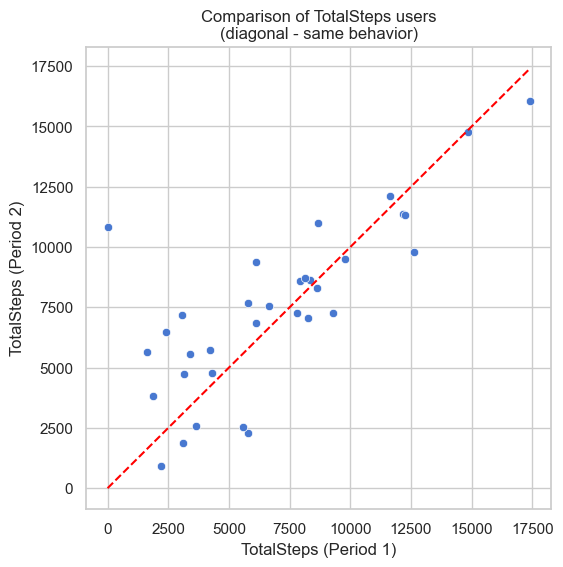

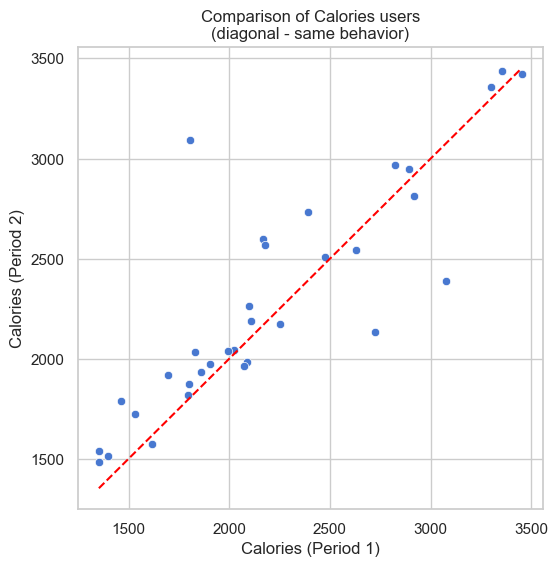

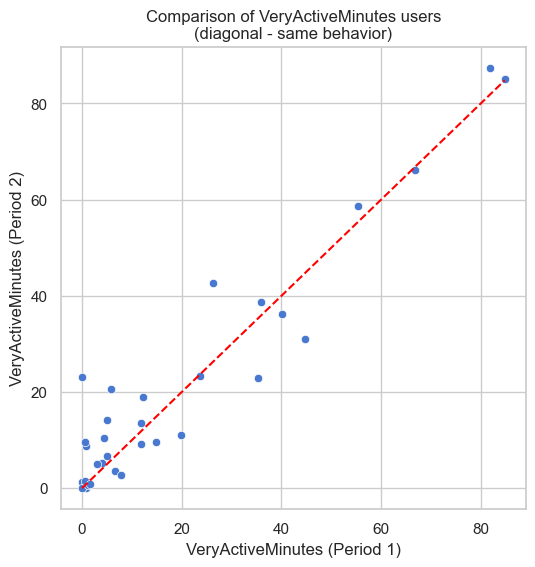

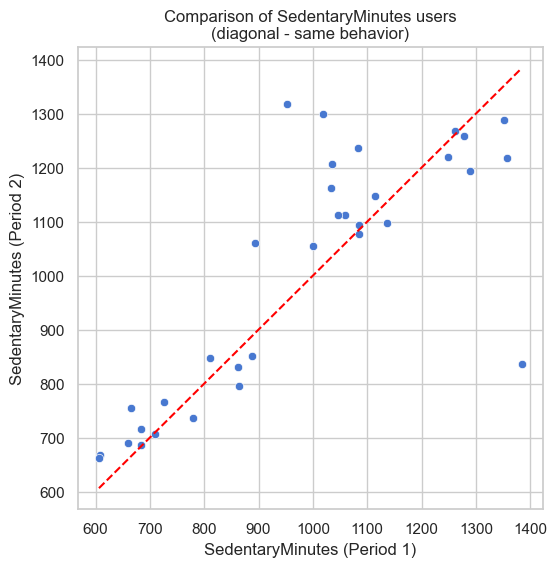

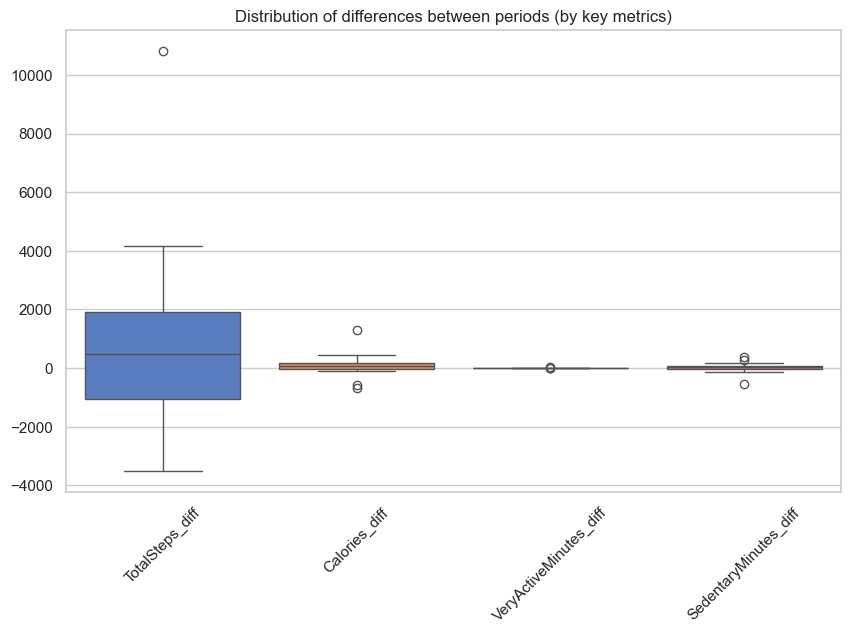


=== Interpretation ===
- If correlations > 0.7: the data is homogeneous (user behavior is stable).
- If correlations are > 0.7: data is homogeneous (user behavior is stable).
- If correlations are 0.4–0.7: moderate differences — behavior has changed slightly.
- If correlations are < 0.4: significant differences, possible changes in data or behavior.



In [61]:
print(f"Common users: {len(common_ids)} out of {activity_daily_1['Id'].nunique()} (first set) "
      f"and {activity_daily_2['Id'].nunique()} (second set)")
a1_common = activity_daily_1[activity_daily_1['Id'].isin(common_ids)]
a2_common = activity_daily_2[activity_daily_2['Id'].isin(common_ids)]
metrics = [
    'TotalSteps', 'TotalDistance', 'TrackerDistance',
    'LoggedActivitiesDistance', 'VeryActiveDistance',
    'ModeratelyActiveDistance', 'LightActiveDistance',
    'SedentaryActiveDistance', 'VeryActiveMinutes',
    'FairlyActiveMinutes', 'LightlyActiveMinutes',
    'SedentaryMinutes', 'Calories'
]
print("\n=== Summary statistics for the FIRST period ===")
print(a1_common[metrics].describe())

print("\n=== Summary statistics for the SECOND period ===")
print(a2_common[metrics].describe())
user_avg_1 = a1_common.groupby('Id')[metrics].mean().add_suffix('_p1')
user_avg_2 = a2_common.groupby('Id')[metrics].mean().add_suffix('_p2')
merged = user_avg_1.merge(user_avg_2, left_index=True, right_index=True)
for m in metrics:
    merged[m + '_diff'] = merged[m + '_p2'] - merged[m + '_p1']
print("\n=== Example of comparison of average users ===")
print(merged.head())
correlations = []
for m in metrics:
    corr = merged[m + '_p1'].corr(merged[m + '_p2'])
    correlations.append((m, round(corr, 3)))
corr_df = pd.DataFrame(correlations, columns=['Metric', 'Correlation'])
print("\n=== Correlations between periods ===")
print(corr_df)
sns.set(style="whitegrid", palette="muted")
key_metrics = ['TotalSteps', 'Calories', 'VeryActiveMinutes', 'SedentaryMinutes']
for m in key_metrics:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=merged[m + '_p1'], y=merged[m + '_p2'])
    plt.xlabel(f"{m} (Period 1)")
    plt.ylabel(f"{m} (Period 2)")
    plt.title(f"Comparison of {m} users\n(diagonal - same behavior)")
    plt.plot(
        [merged[m + '_p1'].min(), merged[m + '_p1'].max()],
        [merged[m + '_p1'].min(), merged[m + '_p1'].max()],
        color='red', linestyle='--'
    )
    plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged[[m + '_diff' for m in key_metrics]])
plt.title("Distribution of differences between periods (by key metrics)")
plt.xticks(rotation=45)
plt.show()
print("\n=== Interpretation ===")
print("- If correlations > 0.7: the data is homogeneous (user behavior is stable).")
print("- If correlations are > 0.7: data is homogeneous (user behavior is stable).")
print("- If correlations are 0.4–0.7: moderate differences — behavior has changed slightly.")
print("- If correlations are < 0.4: significant differences, possible changes in data or behavior.\n")


In [62]:
daily_calories=pd.read_csv(path_2 + "\dailyCalories_merged.csv")
daily_intensity=pd.read_csv(path_2 + "\dailyIntensities_merged.csv")
daily_steps=pd.read_csv(path_2 + "\dailySteps_merged.csv")
daily_calories = daily_calories.rename(columns={'ActivityDay': 'ActivityDate'})
daily_intensity = daily_intensity.rename(columns={'ActivityDay': 'ActivityDate'})
daily_steps = daily_steps.rename(columns={'ActivityDay': 'ActivityDate', 'StepTotal': 'TotalSteps'})
daily_calories['ActivityDate'] = pd.to_datetime(daily_calories['ActivityDate'])
daily_intensity['ActivityDate'] = pd.to_datetime(daily_intensity['ActivityDate'])
daily_steps['ActivityDate'] = pd.to_datetime(daily_steps['ActivityDate'])

In [63]:
# === Checking the number of records matches ===
print("🔹 Checking the number of rows:")
print(f"activity_daily_2: {len(activity_daily_2)}")
print(f"daily_calories: {len(daily_calories)}")
print(f"daily_intensity: {len(daily_intensity)}")
print(f"daily_steps: {len(daily_steps)}\n")

# === Checking the number of records matches ===
keys = ['Id', 'ActivityDate']

# Checking steps
merged_steps = activity_daily_2.merge(daily_steps,on=keys,how='left',suffixes=('_main', '_src'))
steps_diff = (merged_steps['TotalSteps_main'] != merged_steps['TotalSteps_src']).sum()
print(f"🚶 Differences in steps (TotalSteps vs StepTotal): {steps_diff}")

# Checking calories
merged_calories = activity_daily_2.merge(daily_calories, on=keys, how='left', suffixes=('_main', '_src'))
calories_diff = (merged_calories['Calories_main'] != merged_calories['Calories_src']).sum()
print(f"🔥 Differences in calories (Calories): {calories_diff}")

# Checking intensity (by key minutes)
merged_intensity = activity_daily_2.merge(daily_intensity, on=keys, how='left', suffixes=('_main', '_src'))

intensity_cols = [
    'SedentaryMinutes', 'LightlyActiveMinutes', 'FairlyActiveMinutes', 'VeryActiveMinutes',
    'SedentaryActiveDistance', 'LightActiveDistance', 'ModeratelyActiveDistance', 'VeryActiveDistance'
]

diff_counts = {}
for col in intensity_cols:
    diff = (merged_intensity[f"{col}_main"] != merged_intensity[f"{col}_src"]).sum()
    diff_counts[col] = diff

print("\n💪 Differences in activity intensity:")
for k, v in diff_counts.items():
    print(f"{k}: {v}")

# === Final assessment ===
if steps_diff == 0 and calories_diff == 0 and all(v == 0 for v in diff_counts.values()):
    print("\n✅ All data is completely consistent between activity_daily_2 and the original tables.")
else:
    print("\n⚠️ Differences found! Check the mismatched records.")

🔹 Checking the number of rows:
activity_daily_2: 940
daily_calories: 940
daily_intensity: 940
daily_steps: 940

🚶 Differences in steps (TotalSteps vs StepTotal): 0
🔥 Differences in calories (Calories): 0

💪 Differences in activity intensity:
SedentaryMinutes: 0
LightlyActiveMinutes: 0
FairlyActiveMinutes: 0
VeryActiveMinutes: 0
SedentaryActiveDistance: 0
LightActiveDistance: 0
ModeratelyActiveDistance: 0
VeryActiveDistance: 0

✅ All data is completely consistent between activity_daily_2 and the original tables.


## Data process

### Base

In [64]:
dailyActivity = pd.concat([activity_daily_1, activity_daily_2], ignore_index=True)
dailyActivity['ActivityDate'] = pd.to_datetime(dailyActivity['ActivityDate'])
dailyActivity['Id'] = dailyActivity['Id'].astype(str)
dailyActivity["Activity_time"] = dailyActivity[["VeryActiveMinutes", "FairlyActiveMinutes", "LightlyActiveMinutes"]].sum(axis=1)
dailyActivity["Total_active_time"] = dailyActivity[["VeryActiveMinutes", "FairlyActiveMinutes", "LightlyActiveMinutes","SedentaryMinutes"]].sum(axis=1)
dailyActivity['HasLoggedActivity'] = (dailyActivity['LoggedActivitiesDistance'] > 0).astype(int)
dailyActivity=dailyActivity.drop(['LoggedActivitiesDistance', 'TrackerDistance',"SedentaryActiveDistance"],axis='columns')
dailyActivity=dailyActivity[dailyActivity["Calories"] >= 1200]
dailyActivity['day_of_week'] = dailyActivity['ActivityDate'].dt.day_name()
dailyActivity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1349 entries, 0 to 1396
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        1349 non-null   object        
 1   ActivityDate              1349 non-null   datetime64[ns]
 2   TotalSteps                1349 non-null   int64         
 3   TotalDistance             1349 non-null   float64       
 4   VeryActiveDistance        1349 non-null   float64       
 5   ModeratelyActiveDistance  1349 non-null   float64       
 6   LightActiveDistance       1349 non-null   float64       
 7   VeryActiveMinutes         1349 non-null   int64         
 8   FairlyActiveMinutes       1349 non-null   int64         
 9   LightlyActiveMinutes      1349 non-null   int64         
 10  SedentaryMinutes          1349 non-null   int64         
 11  Calories                  1349 non-null   int64         
 12  Activity_time            

In [65]:
dailyActivity.isna().sum()

Id                          0
ActivityDate                0
TotalSteps                  0
TotalDistance               0
VeryActiveDistance          0
ModeratelyActiveDistance    0
LightActiveDistance         0
VeryActiveMinutes           0
FairlyActiveMinutes         0
LightlyActiveMinutes        0
SedentaryMinutes            0
Calories                    0
Activity_time               0
Total_active_time           0
HasLoggedActivity           0
day_of_week                 0
dtype: int64

### Data cleaning

In [66]:
def plot_histograms(df, features):
    n = len(features)
    ncols = 2
    nrows = (n + 1) // ncols
    plt.figure(figsize=(10, nrows * 3))
    for i, feature in enumerate(features, 1):
        plt.subplot(nrows, ncols, i)
        plt.hist(df[feature].dropna(), color='steelblue', edgecolor='black', alpha=0.7)
        plt.title(f"Distribution '{feature}'")
        plt.xlabel(feature)
        plt.ylabel("Quantity")
    plt.tight_layout()
    plt.show()

def log_transform_features(df, features):
    df_log = df.copy()
    for feature in features:
        if feature in df.columns:
            if (df[feature] < 0).any():
                print(f"⚠️ Warning: '{feature}' contains negative values — skipped.")
                continue
            df_log[f"{feature}_log"] = np.log1p(df[feature])
        else:
            print(f"⚠️ Warning: Column '{feature}' not found — skipped.")

    return df_log

def normalize_features(df, columns):
    scaler = RobustScaler()
    df_scaled = df.copy()
    df_scaled[columns] = scaler.fit_transform(df[columns])
    return df_scaled, scaler

def get_outlier_indices_isolation_forest(df, columns, contamination="auto", random_state=42):
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following columns are missing in DataFrame: {missing_cols}")
    data = df[columns].dropna()
    valid_index = data.index
    iso = IsolationForest(
        contamination=contamination,
        random_state=random_state,
        n_estimators=100,
        n_jobs=-1
    )
    preds = iso.fit_predict(data)
    outlier_indices = valid_index[preds == -1]
    print(f"🔍 Found outliers: {len(outlier_indices)} out of {len(df)} rows "
          f"({len(outlier_indices)/len(df)*100:.2f}%)")
    return outlier_indices

def compare_boxplots_multiple(df_before, df_after, columns, color_before="gray", color_after="green"):
    for column in columns:
        combined = pd.concat([
            pd.DataFrame({"value": df_before[column], "dataset": "Before cleaning"}),
            pd.DataFrame({"value": df_after[column], "dataset": "After cleaning"})
        ])
        plt.figure(figsize=(10, 10))
        sns.boxplot(
            data=combined,
            x="dataset",
            y="value",
            palette={"Before cleaning": color_before, "After cleaning": color_after}
        )
        plt.title(f"Boxplot для '{column}' before and after cleaning")
        plt.ylabel(column)
        plt.xlabel("")
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        q25_before, q50_before, q75_before = df_before[column].quantile([0.25, 0.5, 0.75])
        q25_after, q50_after, q75_after = df_after[column].quantile([0.25, 0.5, 0.75])
        plt.text(-0.15, q50_before, f"Med={q50_before:.0f}", color=color_before, ha="right", fontsize=9)
        plt.text(1.15, q50_after, f"Med={q50_after:.0f}", color=color_after, ha="left", fontsize=9)
        plt.text(-0.15, q25_before, f"Q1={q25_before:.0f}", color=color_before, ha="right", fontsize=8)
        plt.text(-0.15, q75_before, f"Q3={q75_before:.0f}", color=color_before, ha="right", fontsize=8)
        plt.text(1.15, q25_after, f"Q1={q25_after:.0f}", color=color_after, ha="left", fontsize=8)
        plt.text(1.15, q75_after, f"Q3={q75_after:.0f}", color=color_after, ha="left", fontsize=8)
        plt.show()

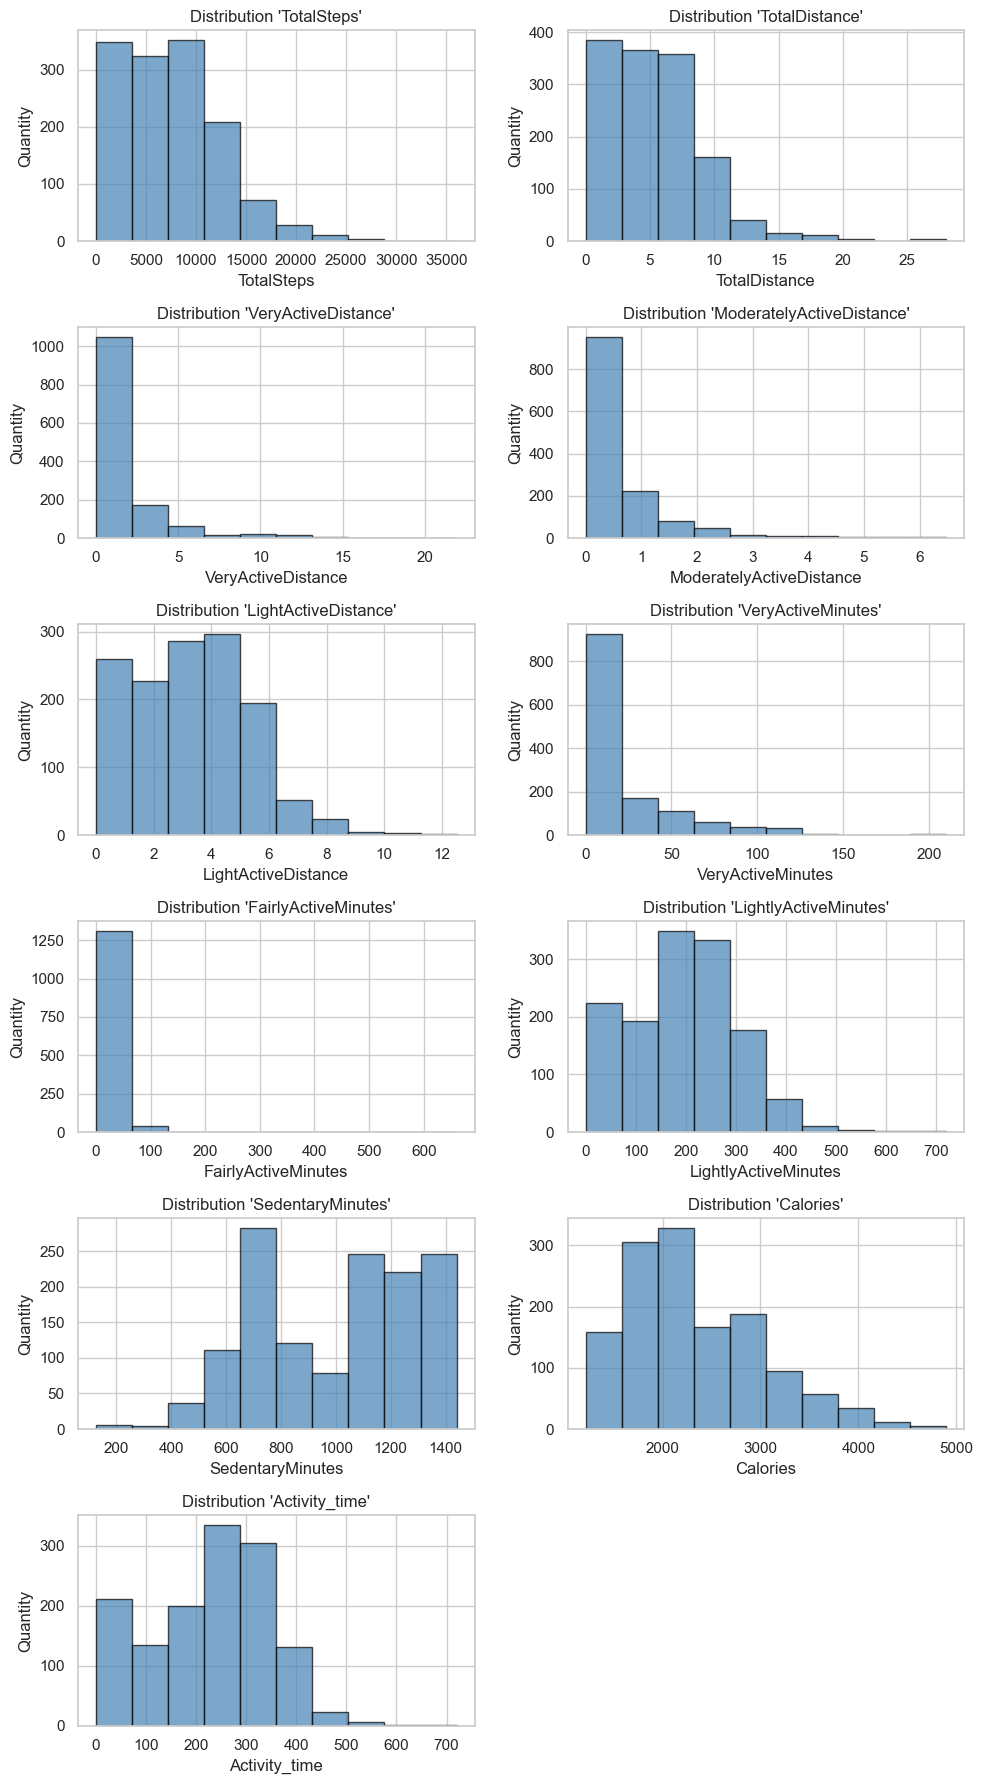

In [67]:
col_to_analysis=['TotalSteps', 'TotalDistance', 'VeryActiveDistance','ModeratelyActiveDistance', 
                'LightActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes','LightlyActiveMinutes', 'SedentaryMinutes', 
                'Calories','Activity_time']
plot_histograms(dailyActivity, col_to_analysis)

In [68]:
cols_to_log = [
    "TotalSteps",
    "TotalDistance",
    "VeryActiveDistance",
    "ModeratelyActiveDistance",
    "LightActiveDistance",
    "VeryActiveMinutes",
    "FairlyActiveMinutes",
    "Calories"
]

df_log = log_transform_features(dailyActivity, cols_to_log)
col_to_analysis_final=list(df_log[[col for col in df_log.columns if col.endswith('_log')]].columns)+list(set(col_to_analysis)-set(cols_to_log))
df_log[col_to_analysis_final].head()

,TotalSteps_log,TotalDistance_log,VeryActiveDistance_log,ModeratelyActiveDistance_log,LightActiveDistance_log,VeryActiveMinutes_log,FairlyActiveMinutes_log,Calories_log,SedentaryMinutes,Activity_time,LightlyActiveMinutes
0,9.306105,2.093098,1.272566,0.378436,1.623341,3.526361,2.564949,7.506592,804,250,205
1,9.776222,2.529721,2.069391,0.548121,1.591274,4.499810,2.890372,7.675546,588,380,274
2,9.452266,2.254445,1.733424,0.148420,1.549688,4.043051,1.791759,7.573017,605,329,268
3,9.490393,2.295561,1.432701,0.582216,1.783391,3.688879,3.044522,7.566828,1080,283,224
4,9.396156,2.180417,1.150572,0.737164,1.724551,3.367296,3.367296,7.542744,763,299,243


🔍 Found outliers: 261 out of 1349 rows (19.35%)


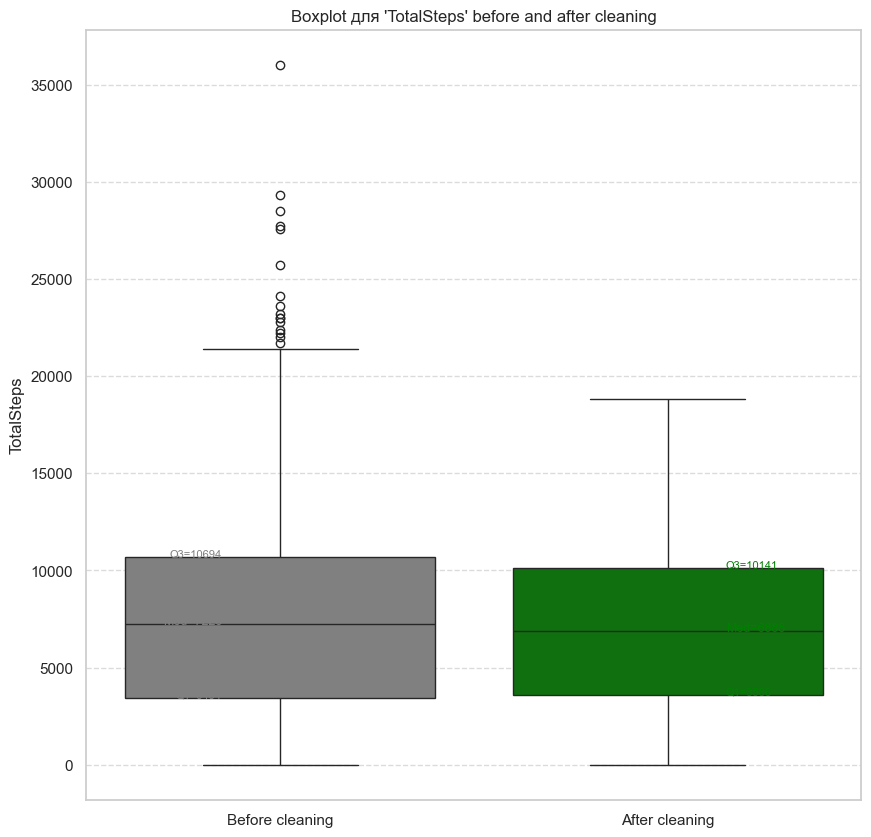

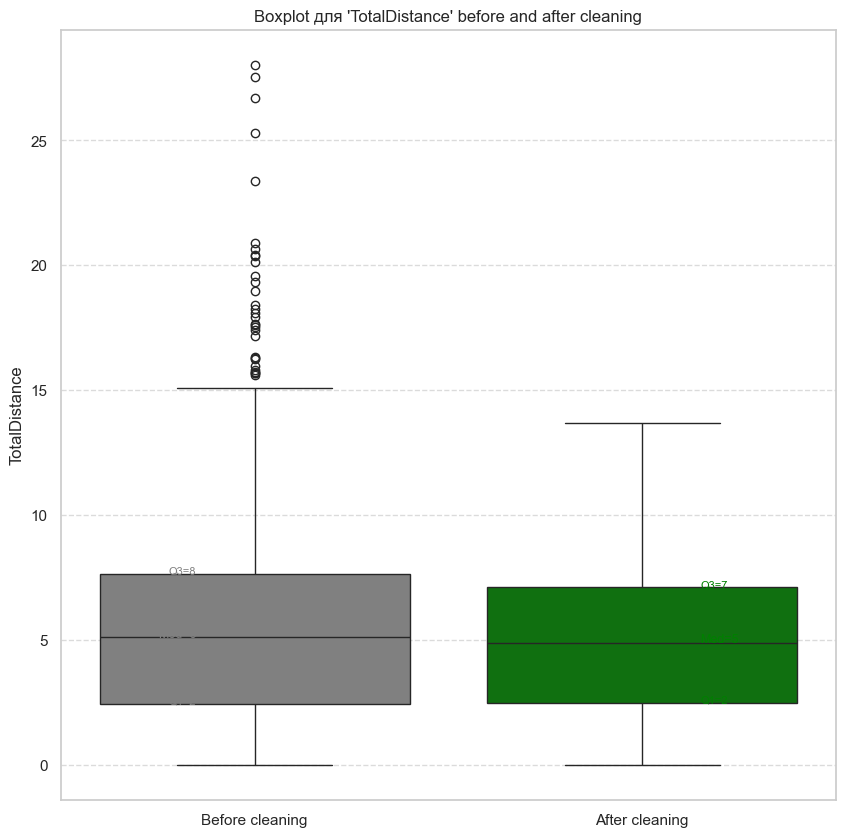

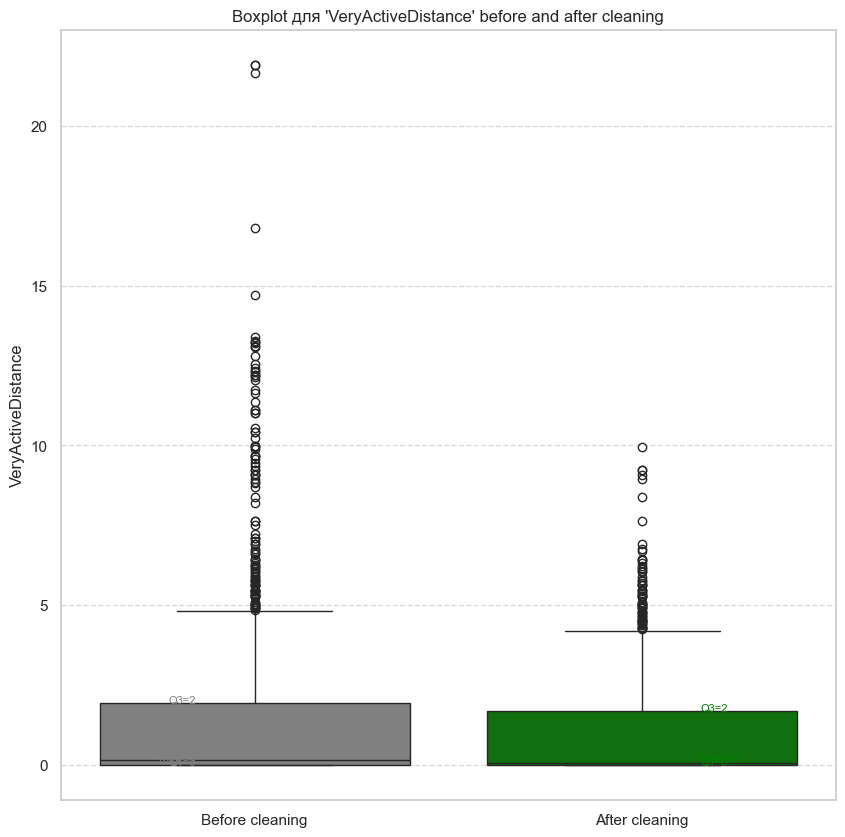

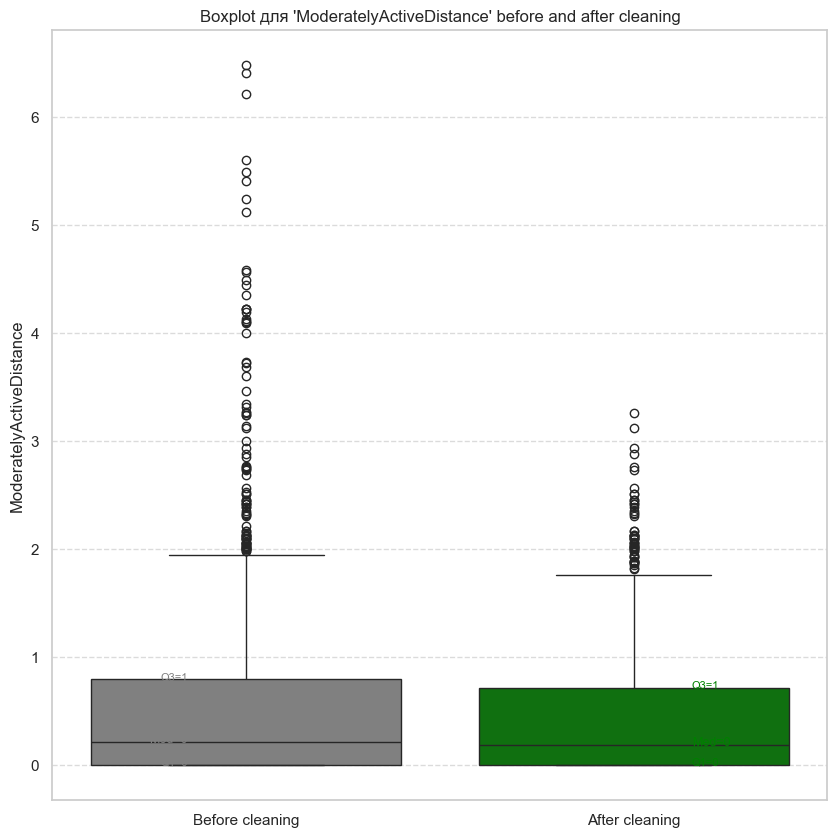

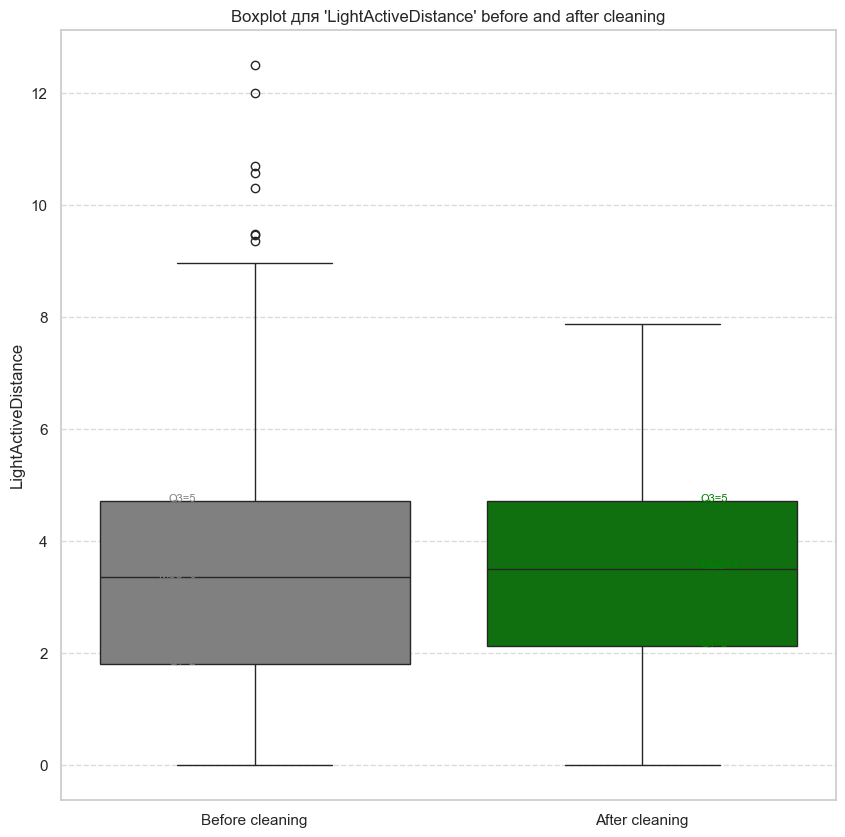

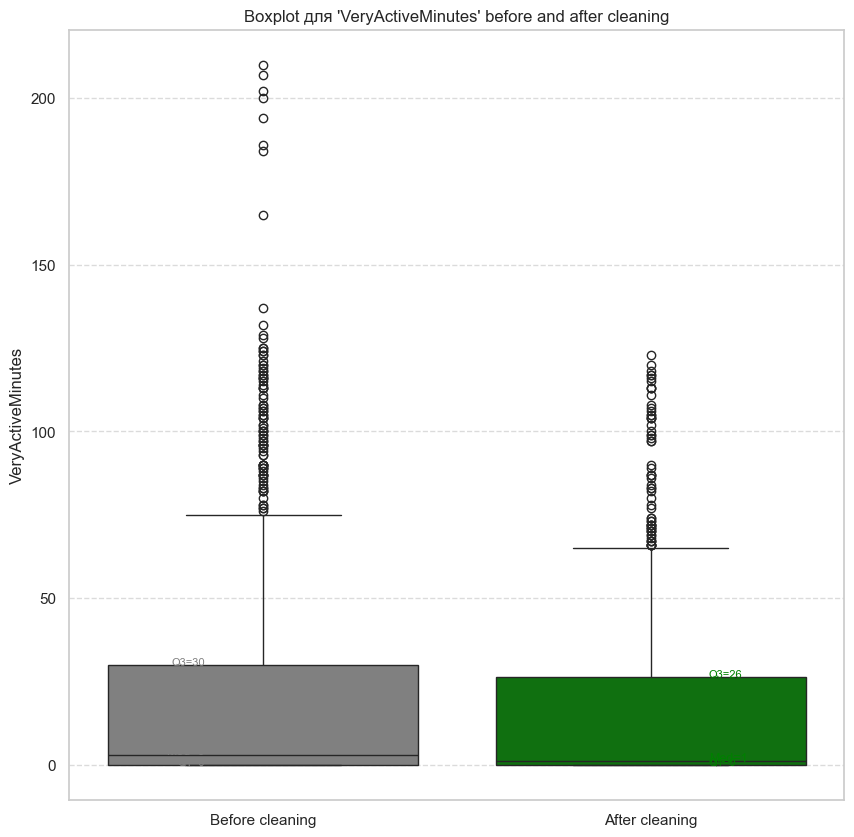

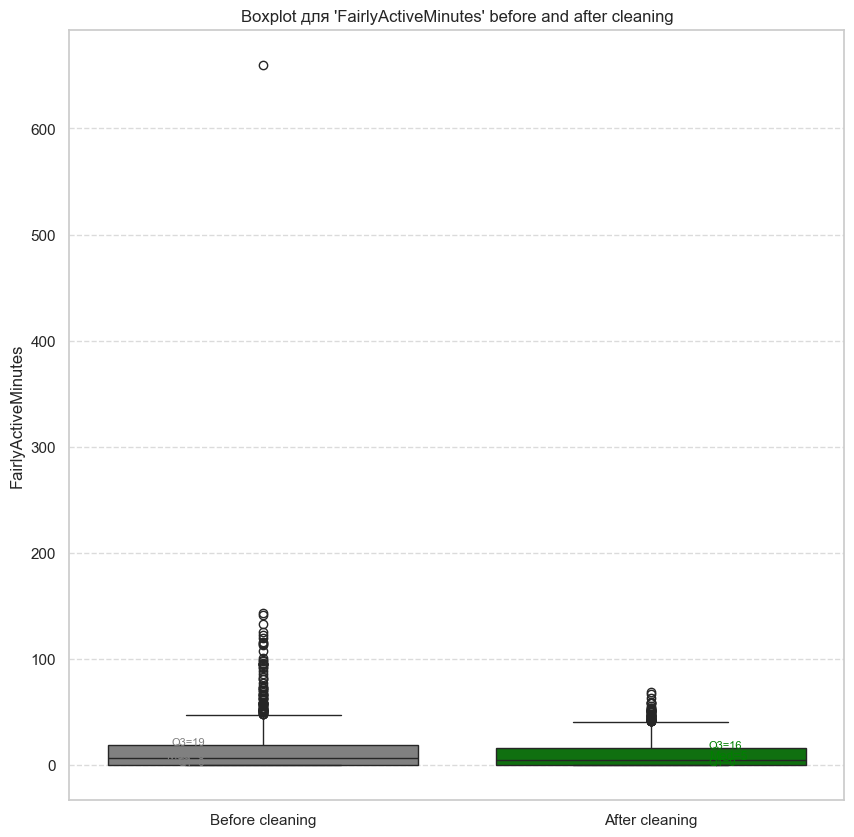

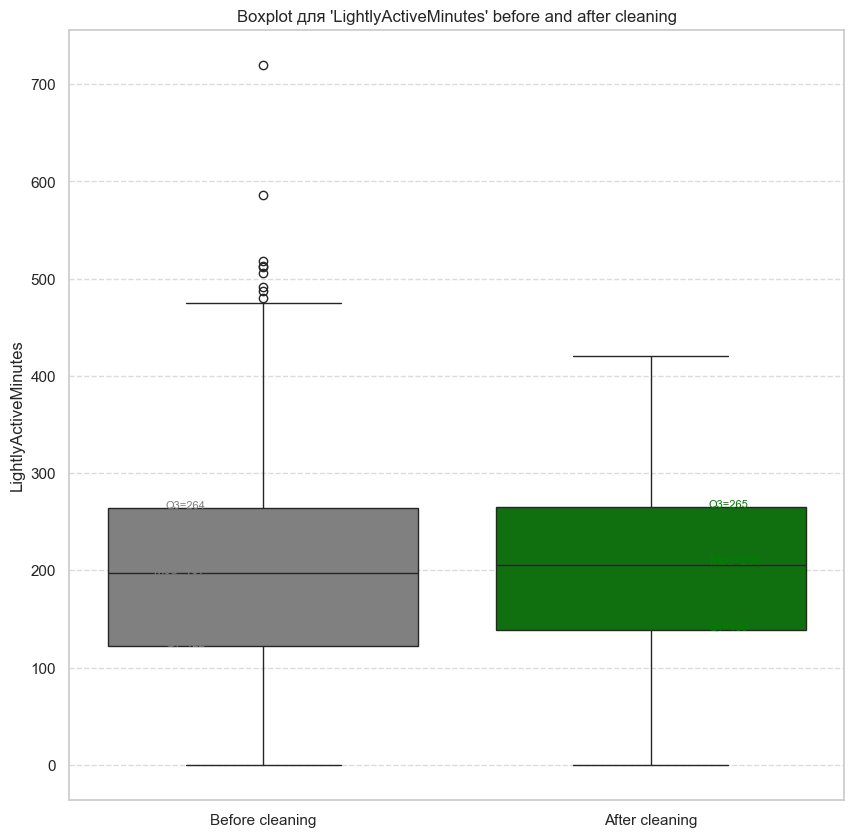

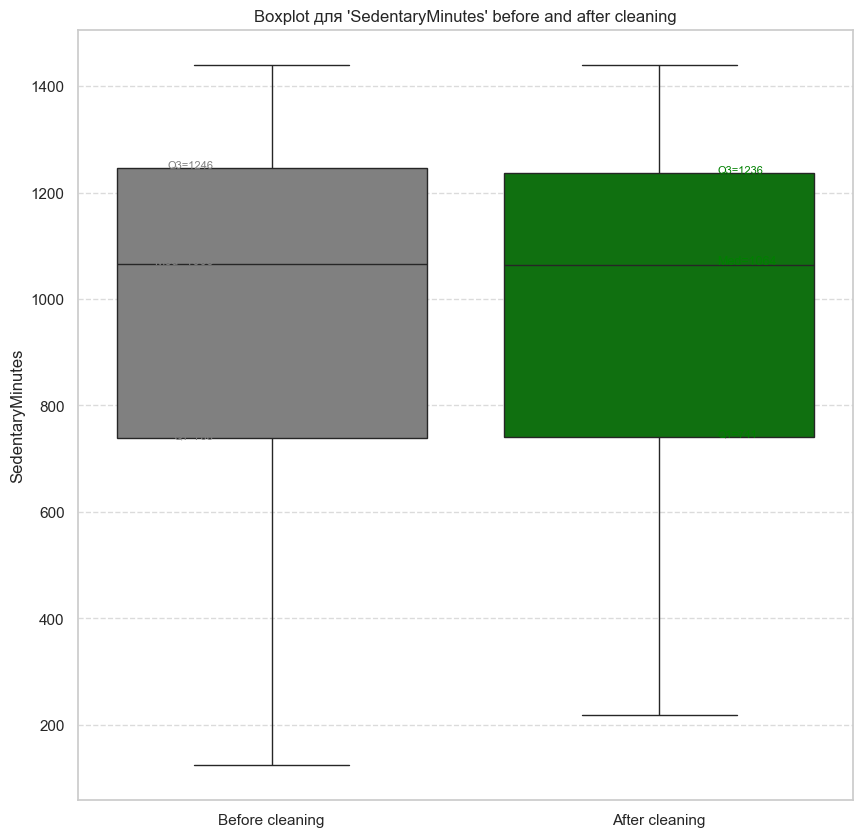

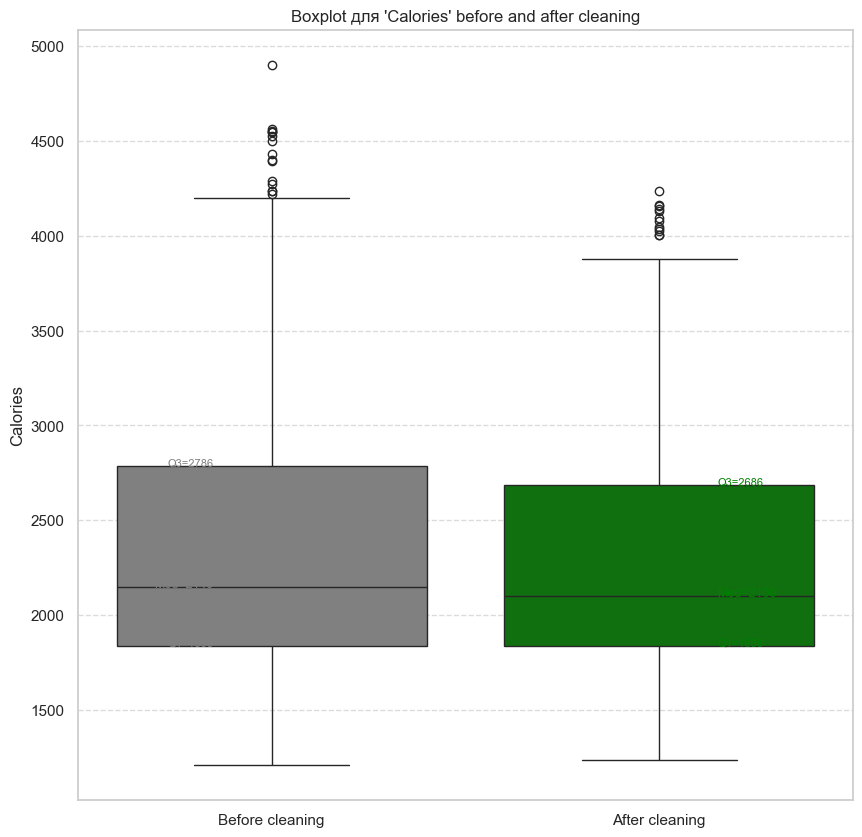

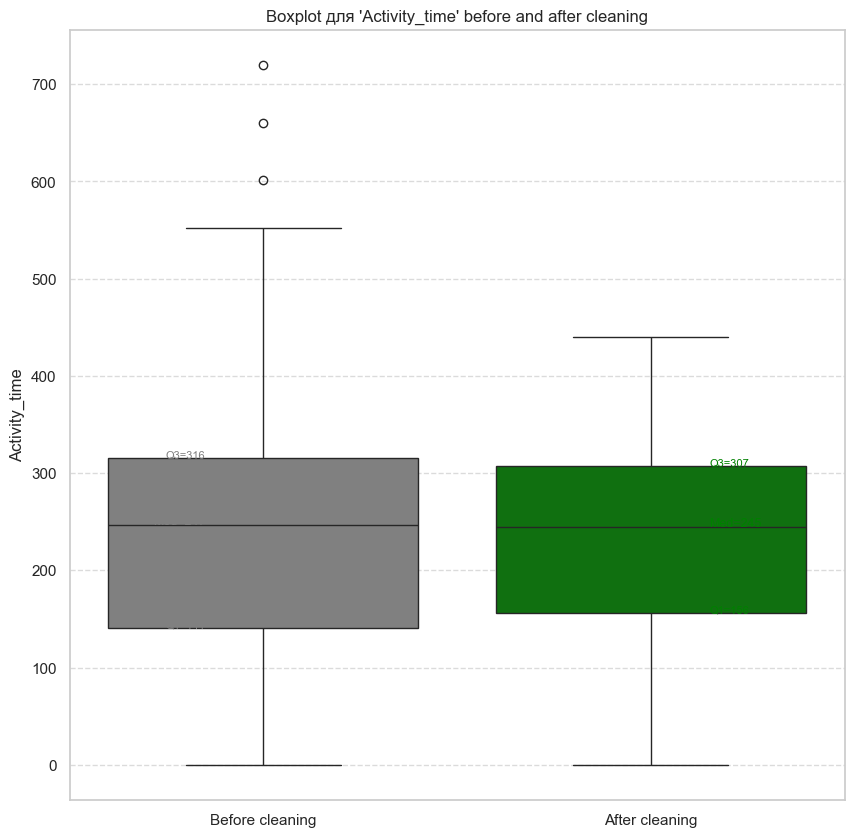

In [69]:
df_normalized, scaler = normalize_features(df_log, col_to_analysis_final)
df_normalized[col_to_analysis_final].describe().T
outlier_idx = get_outlier_indices_isolation_forest(df_normalized, columns=col_to_analysis_final)
df_normalized_2=df_normalized.drop(outlier_idx)
df_normalized[col_to_analysis_final]=scaler.inverse_transform(df_normalized[col_to_analysis_final])
df_normalized_2[col_to_analysis_final]=scaler.inverse_transform(df_normalized_2[col_to_analysis_final])
compare_boxplots_multiple(df_normalized, df_normalized_2, col_to_analysis)

In [70]:
dailyActivity[col_to_analysis].drop(outlier_idx).describe().T

,count,mean,std,min,25%,50%,75%,max
TotalSteps,1088.0,6908.146140,4257.289649,0.0,3586.000,6887.500,10141.0000,18827.00
TotalDistance,1088.0,4.848199,3.035535,0.0,2.475,4.895,7.1000,13.69
VeryActiveDistance,1088.0,1.049642,1.630915,0.0,0.000,0.070,1.6875,9.96
ModeratelyActiveDistance,1088.0,0.442592,0.610858,0.0,0.000,0.180,0.7150,3.26
LightActiveDistance,1088.0,3.319200,1.835599,0.0,2.120,3.505,4.7100,7.88
VeryActiveMinutes,1088.0,16.430147,25.181196,0.0,0.000,1.000,26.2500,123.00
FairlyActiveMinutes,1088.0,10.534007,13.855568,0.0,0.000,5.000,16.2500,69.00
LightlyActiveMinutes,1088.0,195.102022,100.981056,0.0,139.000,206.000,265.2500,420.00
SedentaryMinutes,1088.0,1008.447610,281.829682,218.0,740.750,1064.500,1236.0000,1440.00
Calories,1088.0,2251.142463,595.714778,1237.0,1837.750,2099.500,2685.5000,4234.00


In [73]:
dailyActivity_2=dailyActivity.copy()

In [74]:
dailyActivity=dailyActivity.drop(outlier_idx)

In [75]:
X = dailyActivity[['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes']]
y = dailyActivity['Calories']
model = LinearRegression().fit(X, y)
weights = model.coef_ / model.coef_.sum()
dailyActivity['ActiveRatio'] = (dailyActivity['Activity_time'] / (dailyActivity['Activity_time'] + dailyActivity['SedentaryMinutes']))*100
dailyActivity['IntensityScore'] = (
    dailyActivity['VeryActiveMinutes'] * weights[0] +
    dailyActivity['FairlyActiveMinutes'] * weights[1] +
    dailyActivity['LightlyActiveMinutes'] * weights[2]
)

<Axes: >

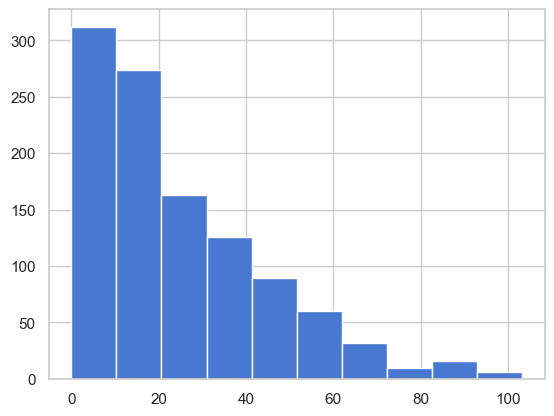

In [76]:
dailyActivity.IntensityScore.hist()

In [77]:
features = [
    'VeryActiveMinutes',
    'FairlyActiveMinutes',
    'LightlyActiveMinutes',
    'VeryActiveDistance', 
    'ModeratelyActiveDistance', 
    'LightActiveDistance',
    'Calories',
    'TotalDistance'
]
values = dailyActivity['IntensityScore'].astype(float).dropna().values
labels = ['Low', 'Medium', 'High']
X_scaled = StandardScaler().fit_transform(dailyActivity[features])
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
dailyActivity['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
cluster_order = (
    dailyActivity.groupby('KMeans_Cluster')['IntensityScore']
    .mean()
    .sort_values()
    .index
)
mapping = {cluster: label for cluster, label in zip(cluster_order, labels)}
dailyActivity['IntensityLevel'] = dailyActivity['KMeans_Cluster'].map(mapping)
dailyActivity=dailyActivity.drop(['KMeans_Cluster'],axis='columns')
print("\nAverage IntensityScore by clusters:")
print(dailyActivity.groupby('IntensityLevel')['IntensityScore'].mean())


Average IntensityScore by clusters:
IntensityLevel
High      49.731311
Low        4.566454
Medium    20.209609
Name: IntensityScore, dtype: float64


In [79]:
dailyActivity['VeryActiveSpeed'] = dailyActivity['VeryActiveDistance'] / (dailyActivity['VeryActiveMinutes'] / 60)
dailyActivity['FairlyActiveSpeed'] = dailyActivity['ModeratelyActiveDistance'] / (dailyActivity['FairlyActiveMinutes'] / 60)
dailyActivity['LightlyActiveSpeed'] = dailyActivity['LightActiveDistance'] / (dailyActivity['LightlyActiveMinutes'] / 60)
dailyActivity['AvgActiveSpeed'] = (
    (dailyActivity['VeryActiveDistance'] + dailyActivity['ModeratelyActiveDistance'] + dailyActivity['LightActiveDistance']) /
    ((dailyActivity['VeryActiveMinutes'] + dailyActivity['FairlyActiveMinutes'] + dailyActivity['LightlyActiveMinutes']) / 60)
)

In [80]:
dailyActivity

,Id,ActivityDate,TotalSteps,TotalDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,...,Total_active_time,HasLoggedActivity,day_of_week,ActiveRatio,IntensityScore,IntensityLevel,VeryActiveSpeed,FairlyActiveSpeed,LightlyActiveSpeed,AvgActiveSpeed
0,1503960366,2016-03-25,11004,7.11,2.57,0.46,4.07,33,12,205,...,1054,0,Friday,23.719165,36.504515,Medium,4.672727,2.300000,1.191220,1.704000
1,1503960366,2016-03-26,17609,11.55,6.92,0.73,3.91,89,17,274,...,968,0,Saturday,39.256198,79.612406,High,4.665169,2.576471,0.856204,1.825263
2,1503960366,2016-03-27,12736,8.53,4.66,0.16,3.71,56,5,268,...,934,0,Sunday,35.224839,53.631887,High,4.992857,1.920000,0.830597,1.555623
3,1503960366,2016-03-28,13231,8.93,3.19,0.79,4.95,39,20,224,...,1363,0,Monday,20.763023,43.724546,High,4.907692,2.370000,1.325893,1.893286
4,1503960366,2016-03-29,12041,7.85,2.16,1.09,4.61,28,28,243,...,1062,0,Tuesday,28.154426,39.370147,High,4.628572,2.335714,1.138272,1.577258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,8877689391,2016-05-05,14055,10.67,5.46,0.82,4.37,67,15,188,...,1440,0,Thursday,18.750000,59.553140,High,4.889552,3.280000,1.394681,2.366667
1391,8877689391,2016-05-07,12332,8.13,0.08,0.96,6.99,105,28,271,...,1440,0,Saturday,28.055556,93.276268,High,0.045714,2.057143,1.547601,1.192574
1392,8877689391,2016-05-08,10686,8.11,1.08,0.20,6.80,17,4,245,...,1440,0,Sunday,18.472222,25.596176,Medium,3.811765,3.000000,1.665306,1.822556
1394,8877689391,2016-05-10,10733,8.15,1.35,0.46,6.28,18,11,224,...,1440,0,Tuesday,17.569444,27.030320,Medium,4.500000,2.509091,1.682143,1.918577


In [81]:
dailyActivity.isna().sum()

Id                            0
ActivityDate                  0
TotalSteps                    0
TotalDistance                 0
VeryActiveDistance            0
ModeratelyActiveDistance      0
LightActiveDistance           0
VeryActiveMinutes             0
FairlyActiveMinutes           0
LightlyActiveMinutes          0
SedentaryMinutes              0
Calories                      0
Activity_time                 0
Total_active_time             0
HasLoggedActivity             0
day_of_week                   0
ActiveRatio                   0
IntensityScore                0
IntensityLevel                0
VeryActiveSpeed             525
FairlyActiveSpeed           494
LightlyActiveSpeed          123
AvgActiveSpeed              123
dtype: int64

In [22]:
path_save="..\Bellabeat data analysis\data\Final_data"
dailyActivity.to_csv(path_save+"\dailyActivity.csv",index=False)

# Hourly

In [23]:
Calories_3_4=pd.read_csv(path_1+"\hourlyCalories_merged.csv")
Calories_4_5=pd.read_csv(path_2+"\hourlyCalories_merged.csv")
Intensities_3_4=pd.read_csv(path_1+"\hourlyIntensities_merged.csv")
Intensities_4_5=pd.read_csv(path_2+"\hourlyIntensities_merged.csv")
Steps_3_4=pd.read_csv(path_1+"\hourlySteps_merged.csv")
Steps_4_5=pd.read_csv(path_2+"\hourlySteps_merged.csv")

In [24]:
Calories_3_4["ActivityHour"]=pd.to_datetime(Calories_3_4["ActivityHour"])
Calories_4_5["ActivityHour"]=pd.to_datetime(Calories_4_5["ActivityHour"])
Intensities_3_4["ActivityHour"]=pd.to_datetime(Intensities_3_4["ActivityHour"])
Intensities_4_5["ActivityHour"]=pd.to_datetime(Intensities_4_5["ActivityHour"])
Steps_3_4["ActivityHour"]=pd.to_datetime(Steps_3_4["ActivityHour"])
Steps_4_5["ActivityHour"]=pd.to_datetime(Steps_4_5["ActivityHour"])

In [25]:
hourly_3_4=pd.merge(pd.merge(Calories_3_4,Intensities_3_4,on=["Id","ActivityHour"]),Steps_3_4,on=["Id","ActivityHour"])
hourly_4_5=pd.merge(pd.merge(Calories_4_5,Intensities_4_5,on=["Id","ActivityHour"]),Steps_4_5,on=["Id","ActivityHour"])
hourly=pd.concat([hourly_3_4,hourly_4_5],ignore_index=True)

In [26]:
hourly

,Id,ActivityHour,Calories,TotalIntensity,AverageIntensity,StepTotal
0,1503960366,2016-03-12 00:00:00,48,0,0.000000,0
1,1503960366,2016-03-12 01:00:00,48,0,0.000000,0
2,1503960366,2016-03-12 02:00:00,48,0,0.000000,0
3,1503960366,2016-03-12 03:00:00,48,0,0.000000,0
4,1503960366,2016-03-12 04:00:00,48,0,0.000000,0
...,...,...,...,...,...,...
46178,8877689391,2016-05-12 10:00:00,126,12,0.200000,514
46179,8877689391,2016-05-12 11:00:00,192,29,0.483333,1407
46180,8877689391,2016-05-12 12:00:00,321,93,1.550000,3135
46181,8877689391,2016-05-12 13:00:00,101,6,0.100000,307


In [27]:
hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46183 entries, 0 to 46182
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                46183 non-null  int64         
 1   ActivityHour      46183 non-null  datetime64[ns]
 2   Calories          46183 non-null  int64         
 3   TotalIntensity    46183 non-null  int64         
 4   AverageIntensity  46183 non-null  float64       
 5   StepTotal         46183 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 2.1 MB


In [28]:
hourly.isna().sum()

Id                  0
ActivityHour        0
Calories            0
TotalIntensity      0
AverageIntensity    0
StepTotal           0
dtype: int64

In [29]:
hourly[['Calories', 'TotalIntensity', 'AverageIntensity','StepTotal']].describe()

,Calories,TotalIntensity,AverageIntensity,StepTotal
count,46183.000000,46183.000000,46183.000000,46183.000000
mean,95.759673,11.404846,0.190081,302.462963
std,60.044212,20.718734,0.345312,677.431448
min,42.000000,0.000000,0.000000,0.000000
25%,62.000000,0.000000,0.000000,0.000000
50%,80.000000,2.000000,0.033333,20.000000
75%,106.000000,15.000000,0.250000,322.000000
max,948.000000,180.000000,3.000000,10565.000000


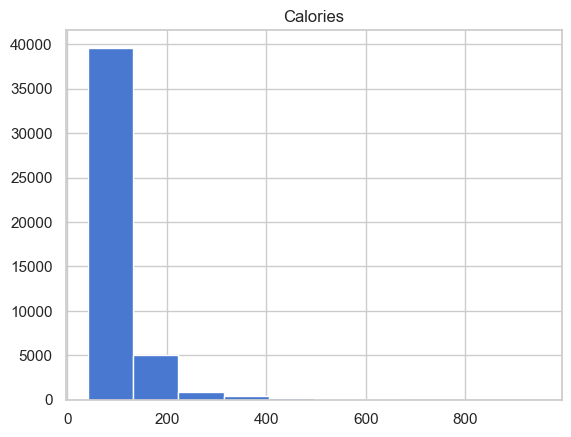

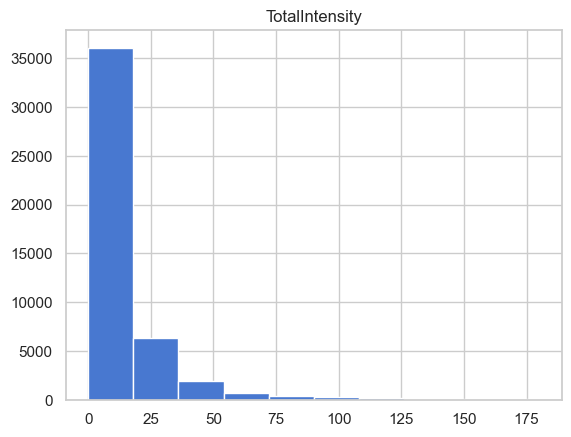

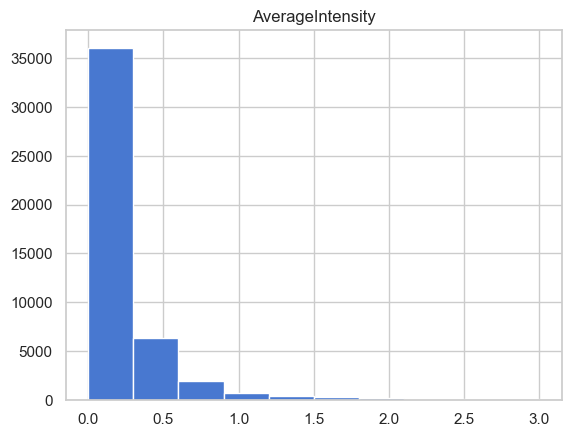

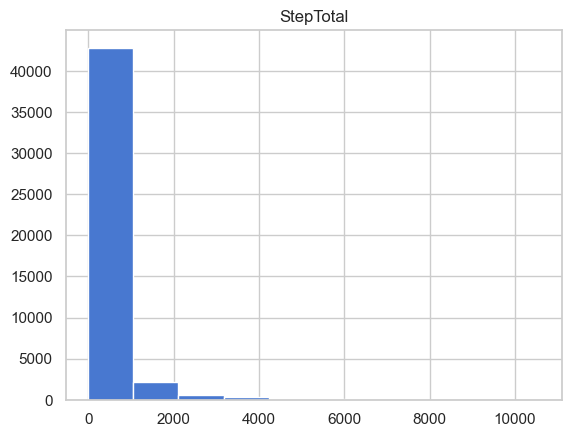

In [30]:
for att in ['Calories', 'TotalIntensity', 'AverageIntensity','StepTotal']:
    hourly[att].hist()
    plt.title(att)
    plt.show()

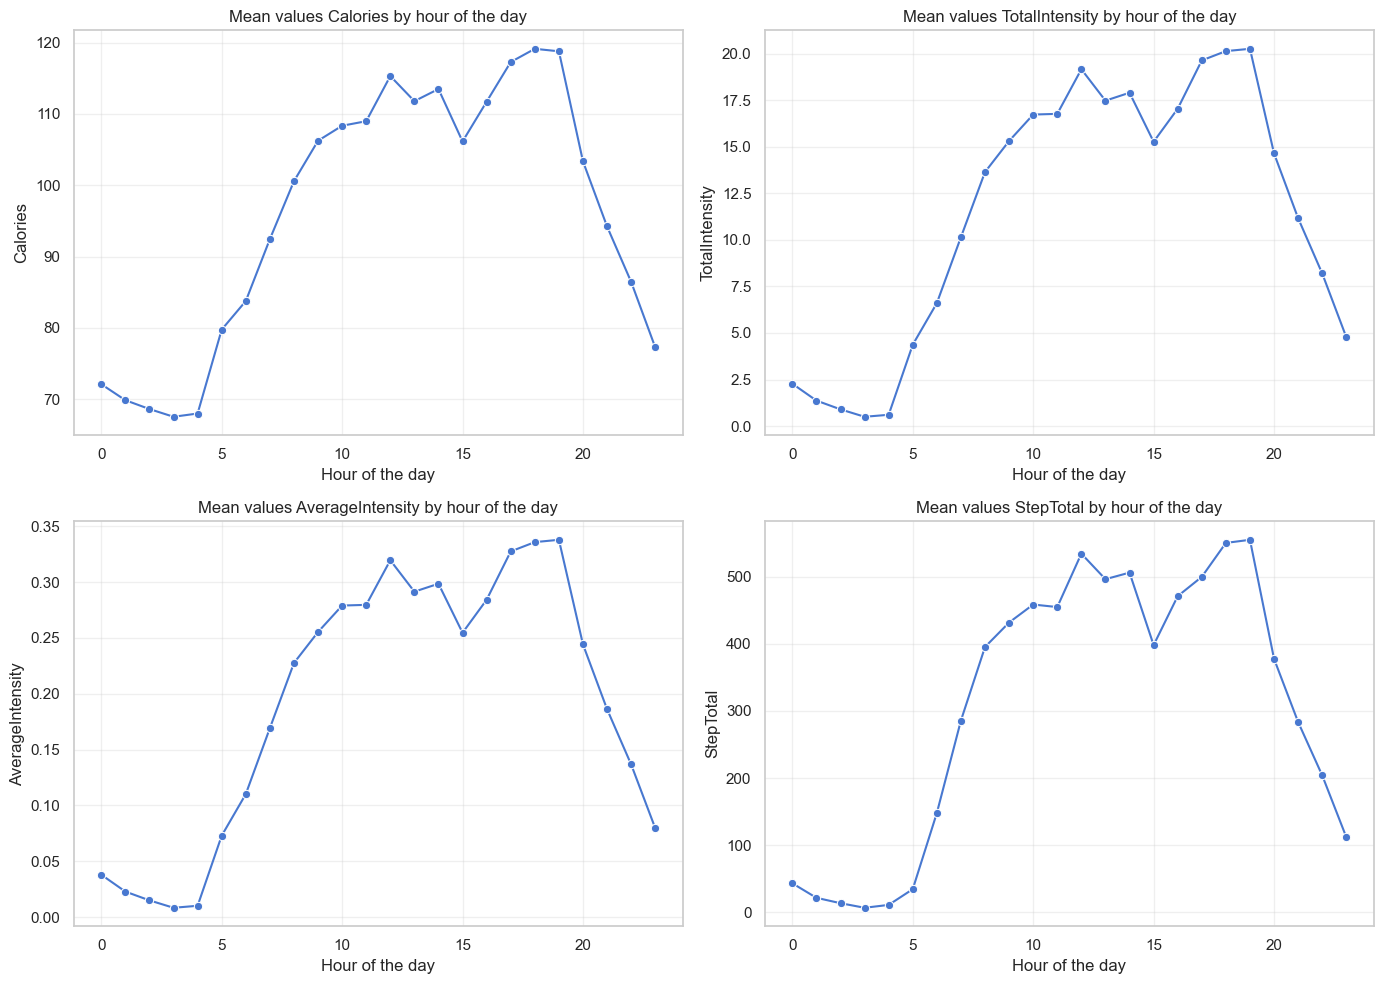

In [31]:
hourly["Hour"]=hourly["ActivityHour"].dt.hour
hourly_stats = hourly.groupby('Hour')[['Calories', 'TotalIntensity', 'AverageIntensity', 'StepTotal']].mean().reset_index()

plt.figure(figsize=(14, 10))

for i, col in enumerate(['Calories', 'TotalIntensity', 'AverageIntensity', 'StepTotal'], 1):
    plt.subplot(2, 2, i)
    sns.lineplot(data=hourly_stats, x='Hour', y=col, marker='o')
    plt.title(f'Mean values {col} by hour of the day')
    plt.xlabel('Hour of the day')
    plt.ylabel(col)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
def time_bound(hour):
    if hour<6:
        return "Night"
    elif 6<=hour<12:
        return "Morning"
    elif 12<=hour<18:
        return "Day"
    else:
        return "Evening"
hourly["day_part"]=hourly["Hour"].apply(lambda x: time_bound(x))
hourly["day_of_week"]=hourly["ActivityHour"].dt.day_name()

In [33]:
hourly.to_csv(path_save+"\hourly.csv",index=False)

# Sleep

In [34]:
sleep_day=pd.read_csv(path_2+"\sleepDay_merged.csv")
sleep_day["SleepDay"]=pd.to_datetime(sleep_day["SleepDay"])
sleep_day["Id"]=sleep_day["Id"].astype(str)
sleep_day["diff"]=sleep_day["TotalTimeInBed"]-sleep_day["TotalMinutesAsleep"]
sleep_day

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,diff
0,1503960366,2016-04-12,1,327,346,19
1,1503960366,2016-04-13,2,384,407,23
2,1503960366,2016-04-15,1,412,442,30
3,1503960366,2016-04-16,2,340,367,27
4,1503960366,2016-04-17,1,700,712,12
...,...,...,...,...,...,...
408,8792009665,2016-04-30,1,343,360,17
409,8792009665,2016-05-01,1,503,527,24
410,8792009665,2016-05-02,1,415,423,8
411,8792009665,2016-05-03,1,516,545,29


In [35]:
sleep_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  413 non-null    object        
 1   SleepDay            413 non-null    datetime64[ns]
 2   TotalSleepRecords   413 non-null    int64         
 3   TotalMinutesAsleep  413 non-null    int64         
 4   TotalTimeInBed      413 non-null    int64         
 5   diff                413 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 19.5+ KB


In [36]:
sleep_day.isna().sum()

Id                    0
SleepDay              0
TotalSleepRecords     0
TotalMinutesAsleep    0
TotalTimeInBed        0
diff                  0
dtype: int64

In [37]:
sleep_day=pd.merge(sleep_day,dailyActivity,left_on=["Id","SleepDay"],right_on=["Id","ActivityDate"])
sleep_day.to_csv(path_save+"\sleep_day.csv",index=False)